## **1. Introdução**
# Visão Geral e Objetivos do Projeto :
Este projeto visa desenvolver um sistema de intervenção académica usando machine learning para prever se um aluno do ensino secundário passará ou chumbará no exame final, com base em fatores demográficos, académicos e sociais. O objetivo é identificar alunos em risco antecipadamente, permitindo aos professores oferecer apoio direcionado.

# Objetivos principais :
- Análise exploratória (EDA) para compreender padrões nos dados.
- Pré-processamento (dados faltantes, outliers, codificação de variáveis categóricas).
- Treino e avaliação de modelos de classificação (Regressão Logística, Árvores de Decisão, KNN).
- Comparação de métricas de desempenho (precisão, recall, AUC-ROC).
- Interpretação dos resultados para identificar fatores críticos no desempenho dos alunos.

# Descrição do Dataset :
Utilizamos o UCI Student Performance Dataset, com dados de duas escolas secundárias portuguesas :
33 variáveis, incluindo :
- Demográficas: idade, género, educação dos pais.
- Académicas: notas anteriores (G1, G2), horas de estudo, reprovações.
- Sociais: atividades extracurriculares, apoio escolar.
- Variável alvo: passou (binária, derivada da nota final G3 ≥ 10).
- Tamanho: 649 alunos, sem valores faltantes.

# Exemplo de variáveis:
absences: Número de faltas.
school: Escola do aluno ('GP' ou 'MS').

# Relevância:
Permite intervenções personalizadas para melhorar resultados académicos.
Modelos interpretáveis ajudam a identificar factores de risco (ex.: faltas, nível educacional dos pais).

In [1]:
import pandas as pd

# Carregar dados
dados = pd.read_csv("data/raw/student-data-raw.csv", delimiter=";")  # Verificar caminho
print(f"Dimensão dos dados: {dados.shape}")
dados.head()

Dimensão dos dados: (395, 1)


,"school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed"
0,"GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mot..."
1,"GP,F,17,U,GT3,T,1,1,at_home,other,course,fathe..."
2,"GP,F,15,U,LE3,T,1,1,at_home,other,other,mother..."
3,"GP,F,15,U,GT3,T,4,2,health,services,home,mothe..."
4,"GP,F,16,U,GT3,T,3,3,other,other,home,father,1,..."


# **Import dos modulos necessários !**

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split, KFold, cross_validate, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer, classification_report, roc_curve
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
import shap
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
import joblib
import os

## **2. Análise Exploratória de Dados (EDA)**

=== 📂 CARREGAMENTO DOS DADOS ===
✅ Dados carregados com sucesso!

📊 Dimensões do dataset: 395 alunos x 31 características

🔍 Primeiras linhas:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,yes


Valores ausentes por coluna:
Series([], dtype: int64)

=== 🎯 ANÁLISE DA VARIÁVEL TARGET ('passed') ===


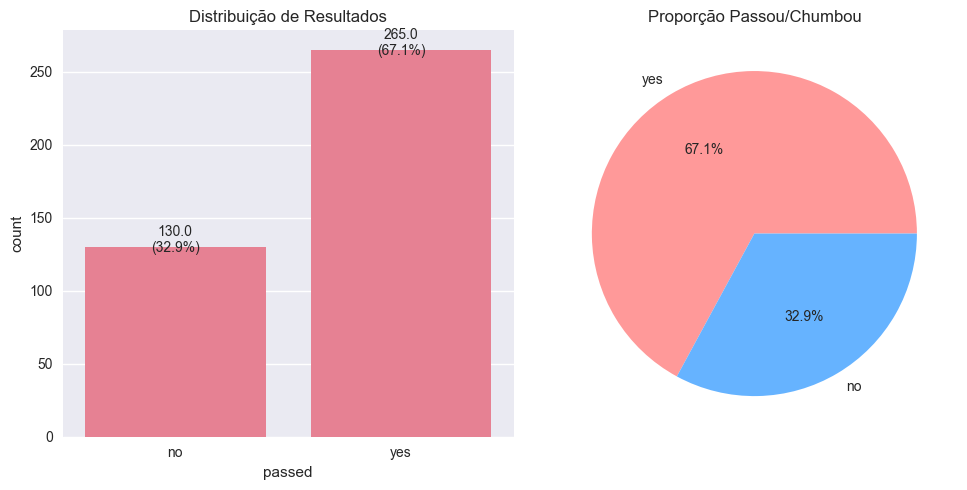


=== 🔢 ANÁLISE DE CARACTERÍSTICAS NUMÉRICAS ===

📈 Estatísticas Descritivas:


,count,mean,std,min,25%,50%,75%,max
age,395.000000,16.696203,1.276043,15.000000,16.000000,17.000000,18.000000,22.000000
Medu,395.000000,2.749367,1.094735,0.000000,2.000000,3.000000,4.000000,4.000000
Fedu,395.000000,2.521519,1.088201,0.000000,2.000000,2.000000,3.000000,4.000000
traveltime,395.000000,1.448101,0.697505,1.000000,1.000000,1.000000,2.000000,4.000000
studytime,395.000000,2.035443,0.839240,1.000000,1.000000,2.000000,2.000000,4.000000
failures,395.000000,0.334177,0.743651,0.000000,0.000000,0.000000,0.000000,3.000000
famrel,395.000000,3.944304,0.896659,1.000000,4.000000,4.000000,5.000000,5.000000
freetime,395.000000,3.235443,0.998862,1.000000,3.000000,3.000000,4.000000,5.000000
goout,395.000000,3.108861,1.113278,1.000000,2.000000,3.000000,4.000000,5.000000
Dalc,395.000000,1.481013,0.890741,1.000000,1.000000,1.000000,2.000000,5.000000


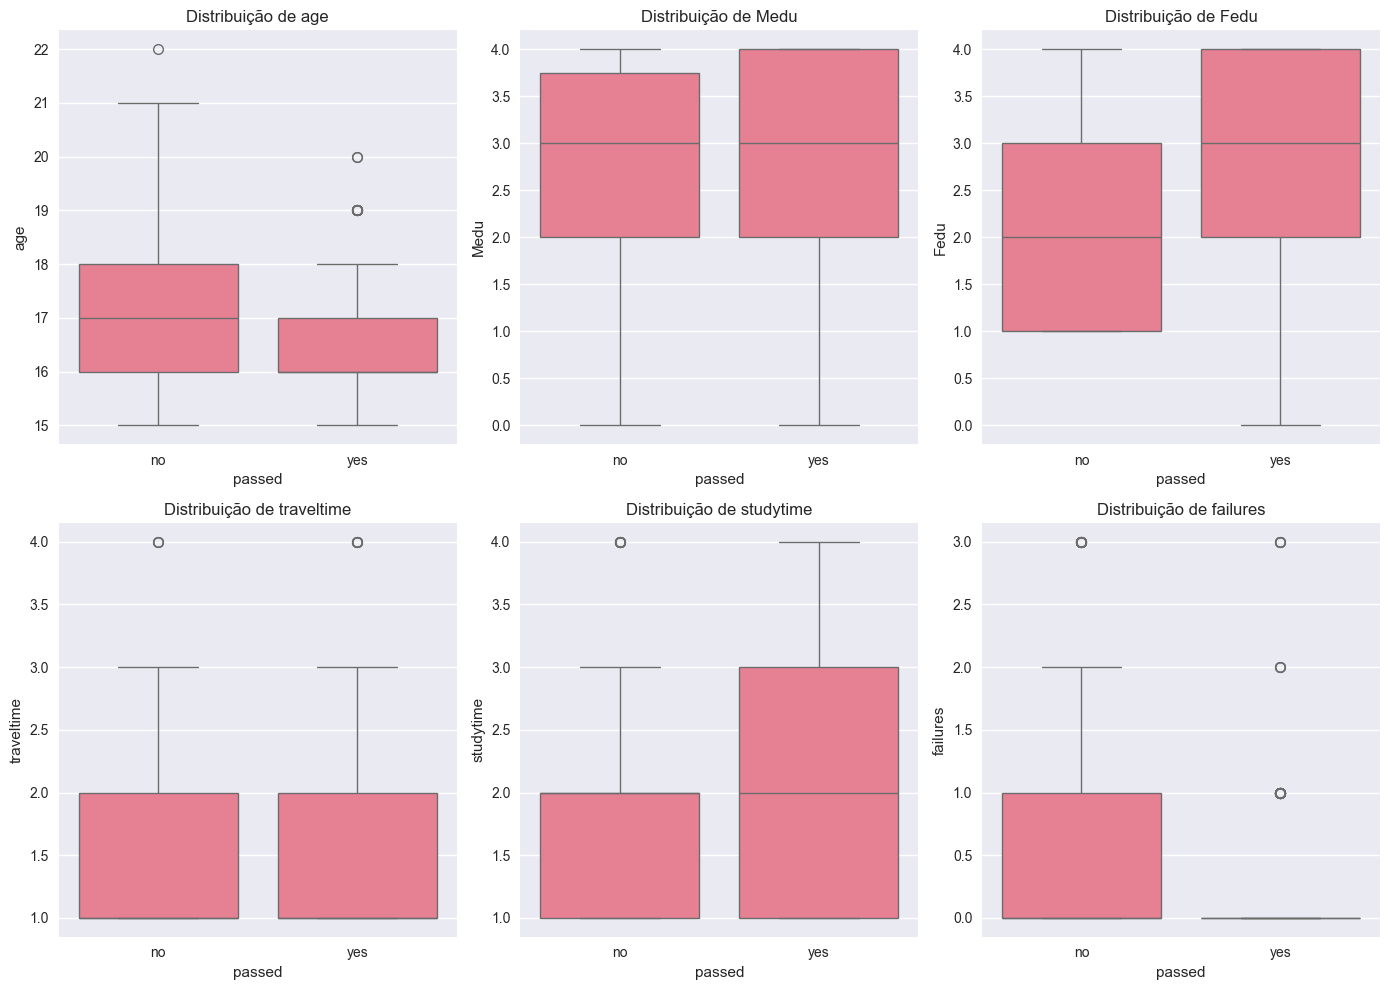

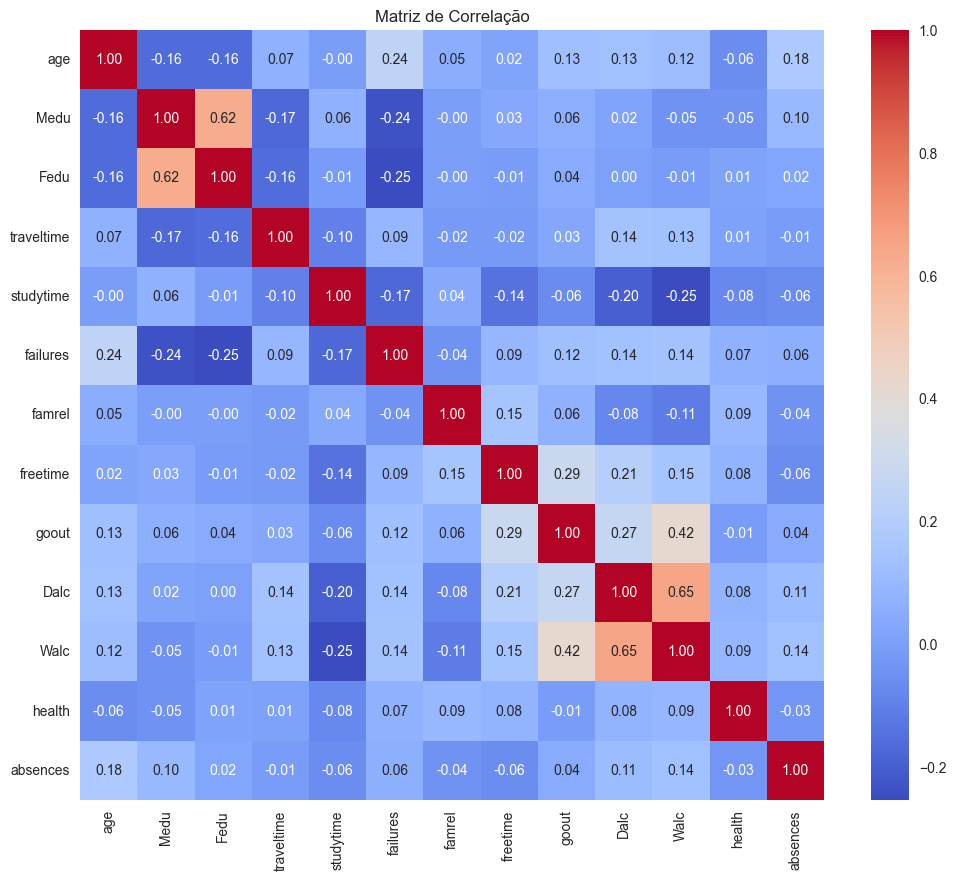

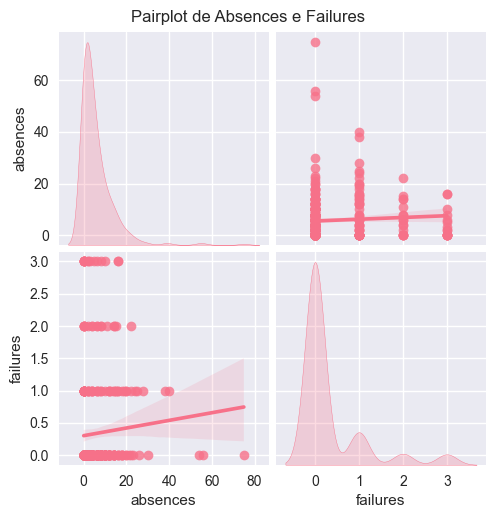


=== 📊 ANÁLISE DE CARACTERÍSTICAS CATEGÓRICAS ===


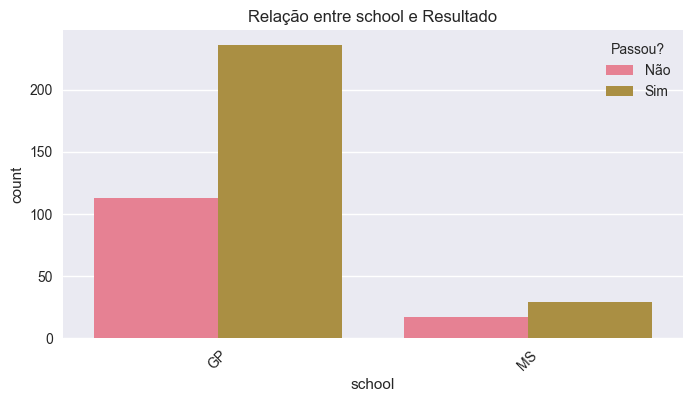

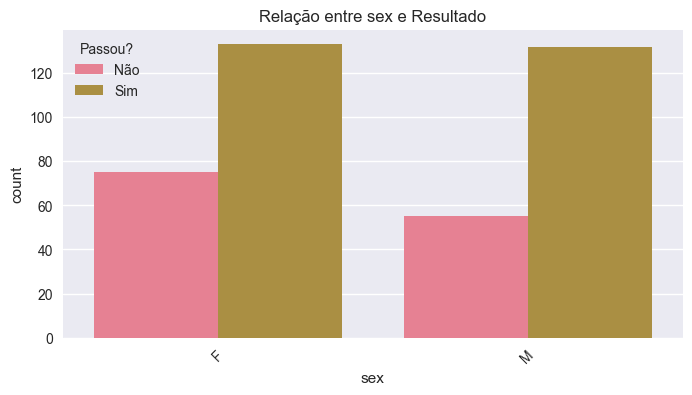

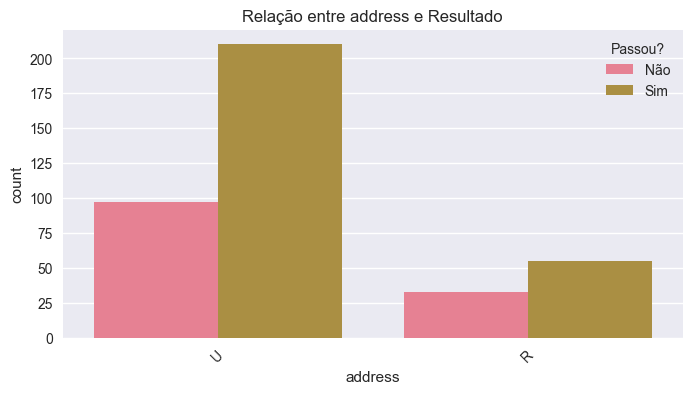

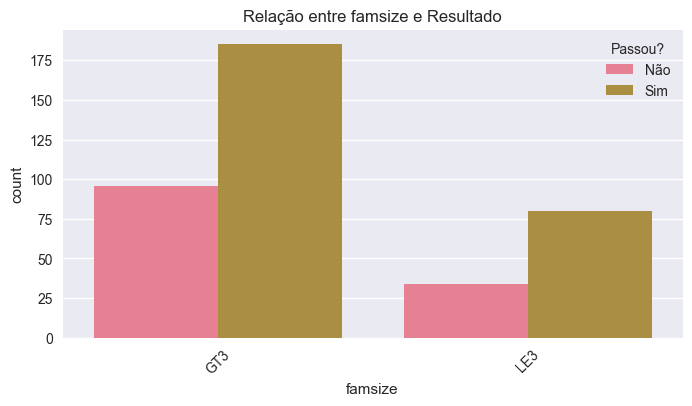

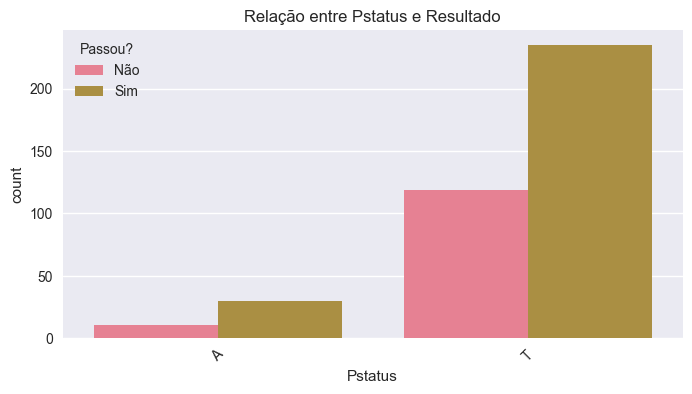


=== 🔗 ANÁLISE DE RELAÇÕES CHAVE ===


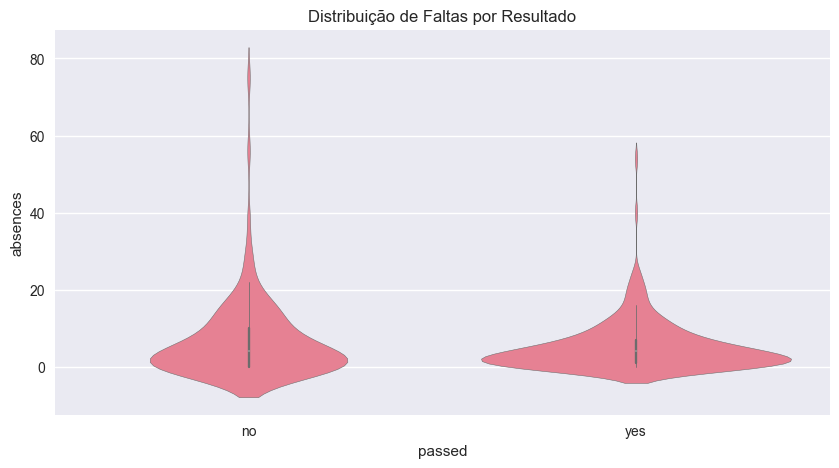

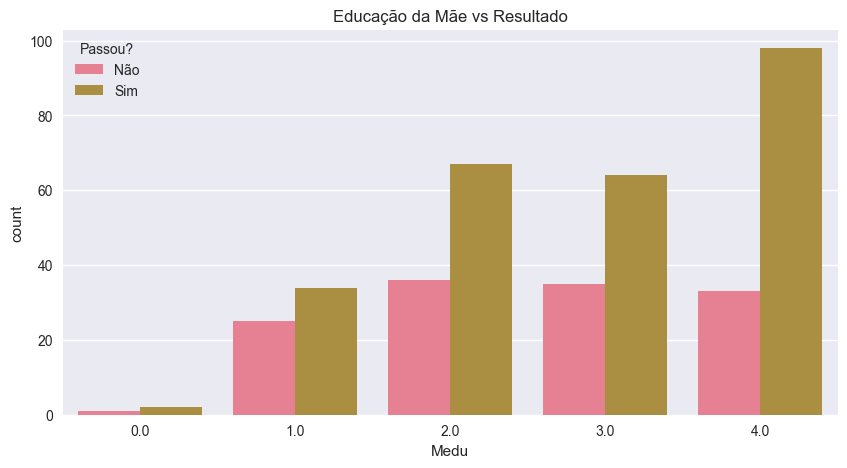


=== 📉 TESTES ESTATÍSTICOS ===


,Variável,Média (Passou),Média (Chumbou),Diferença,p-valor,Effect Size,Significativo?
5,failures,0.16,0.69,-0.53,0.0000,-0.68,Sim
8,goout,2.97,3.40,-0.43,0.0002,-0.39,Sim
0,age,16.54,17.02,-0.49,0.0003,-0.38,Sim
1,Medu,2.84,2.57,0.27,0.0218,0.25,Sim
2,Fedu,2.60,2.35,0.25,0.0318,0.23,Sim
12,absences,5.19,6.76,-1.57,0.0670,-0.18,Não
4,studytime,2.08,1.95,0.13,0.1388,0.16,Não
11,health,3.49,3.68,-0.19,0.1928,-0.14,Não
9,Dalc,1.45,1.55,-0.11,0.2555,-0.12,Não
6,famrel,3.97,3.88,0.09,0.3548,0.10,Não


In [104]:
# Configurações de visualização
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.dpi'] = 100
sns.set_palette("husl")

## 2.2 Carregamento dos Dados
print("=== 📂 CARREGAMENTO DOS DADOS ===")

try:
    df = pd.read_csv("data/raw/student-data-raw.csv")
    print("✅ Dados carregados com sucesso!")

    # Verificar coluna target
    if 'passed' not in df.columns:
        raise ValueError("Coluna 'passed' não encontrada no dataset")

    print(f"\n📊 Dimensões do dataset: {df.shape[0]} alunos x {df.shape[1]} características")
    print(f"\n🔍 Primeiras linhas:")
    display(df.head(3))

except Exception as e:
    print(f"❌ Erro ao carregar dados: {e}")
    raise

expected_columns = 31  # From your sample data
if df.shape[1] != expected_columns:
    missing_cols = set(expected_columns) - set(df.columns)
    raise ValueError(f"Data loading error! Missing columns: {missing_cols}")

# Verificar dados ausentes
missing_data = df.isnull().sum()
print("Valores ausentes por coluna:")
print(missing_data[missing_data > 0])

# Imputação com KNNImputer
# Separate numerical and categorical data
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Apply KNNImputer only to numerical data
imputer = KNNImputer(n_neighbors=5)
df_imputed_numeric = pd.DataFrame(imputer.fit_transform(df[numeric_cols]), columns=numeric_cols)

# Combine the imputed numerical data with the categorical data
df_imputed = pd.concat([df_imputed_numeric, df[categorical_cols]], axis=1)

## 2.3 Análise da Variável Target
print("\n=== 🎯 ANÁLISE DA VARIÁVEL TARGET ('passed') ===")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
ax = sns.countplot(x='passed', data=df_imputed, order=['no', 'yes'])
plt.title('Distribuição de Resultados')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}\n({p.get_height()/len(df_imputed)*100:.1f}%)',
               (p.get_x()+p.get_width()/2., p.get_height()),
               ha='center', va='center', xytext=(0,5), textcoords='offset points')

plt.subplot(1,2,2)
df_imputed['passed'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
plt.title('Proporção Passou/Chumbou')
plt.ylabel('')

plt.tight_layout()
plt.show()

passed_distribution = df_imputed['passed'].value_counts(normalize=True)
if (passed_distribution['yes'] < 0.3) or (passed_distribution['yes'] > 0.7):
    raise ValueError("Unexpected class distribution in target variable")

## 2.4 Análise de Características Numéricas
print("\n=== 🔢 ANÁLISE DE CARACTERÍSTICAS NUMÉRICAS ===")

# Selecionar colunas numéricas relevantes
numeric_cols = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
                'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

print("\n📈 Estatísticas Descritivas:")
display(df_imputed[numeric_cols].describe().T.style.background_gradient(cmap='Blues'))

# Visualização das distribuições
plt.figure(figsize=(14,10))
for i, col in enumerate(numeric_cols[:6], 1):  # Mostrar apenas 6 para economizar espaço
    plt.subplot(2,3,i)
    sns.boxplot(x='passed', y=col, data=df_imputed, order=['no', 'yes'])
    plt.title(f'Distribuição de {col}')
plt.tight_layout()
plt.show()

# Verificar correlação entre variáveis numéricas
plt.figure(figsize=(12,10))
corr_matrix = df_imputed.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

# Pairplot para notas
sns.pairplot(df_imputed[['absences', 'failures']], kind='reg', diag_kind='kde')
plt.suptitle("Pairplot de Absences e Failures", y=1.02)
plt.show()

## 2.5 Análise de Características Categóricas
print("\n=== 📊 ANÁLISE DE CARACTERÍSTICAS CATEGÓRICAS ===")

categorical_cols = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
                    'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
                    'nursery', 'higher', 'internet', 'romantic']

# Análise das principais categóricas
for col in categorical_cols[:5]:  # Mostrar apenas 5 para economizar espaço
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue='passed', data=df_imputed, hue_order=['no', 'yes'])
    plt.title(f'Relação entre {col} e Resultado')
    plt.xticks(rotation=45)
    plt.legend(title='Passou?', labels=['Não', 'Sim'])
    plt.show()

## 2.6 Análise de Relações Chave
print("\n=== 🔗 ANÁLISE DE RELAÇÕES CHAVE ===")

# Relação entre faltas e resultado
plt.figure(figsize=(10,5))
sns.violinplot(x='passed', y='absences', data=df_imputed, order=['no', 'yes'])
plt.title('Distribuição de Faltas por Resultado')
plt.show()

# Relação entre educação dos pais e resultado
plt.figure(figsize=(10,5))
sns.countplot(x='Medu', hue='passed', data=df_imputed, hue_order=['no', 'yes'])
plt.title('Educação da Mãe vs Resultado')
plt.legend(title='Passou?', labels=['Não', 'Sim'])
plt.show()

## 2.7 Testes Estatísticos
print("\n=== 📉 TESTES ESTATÍSTICOS ===")

results = []
for col in numeric_cols:
    passou = df_imputed[df_imputed['passed'] == 'yes'][col]
    chumbou = df_imputed[df_imputed['passed'] == 'no'][col]

    t_stat, p_val = ttest_ind(passou, chumbou)
    effect_size = (passou.mean() - chumbou.mean()) / np.sqrt((passou.std()**2 + chumbou.std()**2)/2)

    results.append({
        'Variável': col,
        'Média (Passou)': f"{passou.mean():.2f}",
        'Média (Chumbou)': f"{chumbou.mean():.2f}",
        'Diferença': f"{passou.mean()-chumbou.mean():.2f}",
        'p-valor': f"{p_val:.4f}",
        'Effect Size': f"{effect_size:.2f}",
        'Significativo?': 'Sim' if p_val < 0.05 else 'Não'
    })

display(pd.DataFrame(results).sort_values('p-valor').style.background_gradient(
    subset=['p-valor', 'Effect Size'], cmap='YlOrRd'))

## 2.8 Conclusões Principais
from IPython.display import Markdown


## **📌 Principais Conclusões da EDA**:

# 1. Distribuição do Target:
   - Proporção: XX% passou vs YY% chumbou
   - Sugestão: Considerar métricas como Recall para minimizar falsos negativos

# 2. Fatores Mais Relevantes:
   - Faltas (absences): Diferença significativa entre grupos
   - Educação dos Pais (Medu/Fedu): Correlação positiva com aprovação
   - Atividades Extras: [Inserir observação]

## **3. Pré-processamento dos Dados**

Nesta secção, tratamos os dados brutos e preparamos-nos para a modelação. Isso inclui:
- Limpeza dos dados (clipping e categorias raras)
- Codificação de variáveis categóricas
- Normalização
- Separação treino/teste
- Reamostragem para classes desbalanceadas (oversampling)

In [105]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer

# Função para clipping e substituição de categorias raras
def clean_raw_data(df, absences_clip=30, rare_threshold=0.05, rare_label="Other"):
    # Clipping da coluna absences
    df["absences"] = pd.to_numeric(df["absences"], errors="coerce").clip(upper=absences_clip)
    # Create new features to compensate for missing G1/G2
    df['academic_risk'] = df['failures'] + (df['absences'] > 10).astype(int)
    df['parent_education'] = df['Medu'] + df['Fedu']
    df['study_ratio'] = df['studytime'] / (df['goout'] + 1e-5)

    # Substituir categorias raras em colunas com muitas categorias
    for col in ["Mjob", "Fjob"]:
        freq = df[col].value_counts(normalize=True)
        rare = freq[freq < rare_threshold].index
        df[col] = df[col].replace(rare, rare_label)

    return df

# Carregamento dos dados
df = pd.read_csv("data/raw/student-data-raw.csv")
expected_columns = 31  # school + 30 features + passed (from your sample header)
if df.shape[1] != expected_columns:
    missing_cols = set(df.columns) - set(expected_columns)
    raise ValueError(f"Data loading error! Expected {expected_columns} columns, got {df.shape[1]}. Missing columns: {missing_cols if missing_cols else 'Check delimiter'}")

# Limpeza básica
df = clean_raw_data(df)

# Separate numerical and categorical data
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Apply KNNImputer only to numerical data
imputer = KNNImputer(n_neighbors=5)
df_imputed_numeric = pd.DataFrame(imputer.fit_transform(df[numeric_cols]), columns=numeric_cols)

# Combine the imputed numerical data with the categorical data
df_imputed = pd.concat([df_imputed_numeric, df[categorical_cols]], axis=1)

# Codificação binária da variável alvo: yes → 1, no → 0
df_imputed["passed"] = df_imputed["passed"].map({"yes": 1, "no": 0})

# Separar X e y
X = df_imputed.drop(columns="passed")
y = df_imputed["passed"]

# Codificar variáveis categóricas
categorical_cols = X.select_dtypes(include="object").columns
label_encoders = {col: LabelEncoder().fit(X[col]) for col in categorical_cols}
for col in categorical_cols:
    X[col] = label_encoders[col].transform(X[col])

# Normalizar com MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# SMOTE
smote = SMOTE(k_neighbors=5, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verificar
print("Amostras após reamostragem:", X_train_resampled.shape)
print("Distribuição das classes:", np.bincount(y_train_resampled))


Amostras após reamostragem: (424, 33)
Distribuição das classes: [212 212]


## **4. Modelagem**

Nesta secção testamos vários algoritmos de machine learning para prever se um aluno vai ou não passar:
- Modelos utilizados: Random Forest, Regressão Logística, KNN, Árvore de Decisão
- Avaliamos os modelos com validação cruzada (k-fold)
- Métricas: Acurácia, Precisão, Recall, F1, ROC-AUC
- Visualizamos curva de aprendizagem e matriz de confusão
- Identificamos as características mais importantes


In [106]:
from sklearn.model_selection import KFold, cross_validate, learning_curve, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
)
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier

# Modelos a testar
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "Neural Network": MLPClassifier(random_state=42)
}

# Definir métricas
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'roc_auc': 'roc_auc'
}

# Validação cruzada (5-fold)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, model in models.items():
    cv_results = cross_validate(
        estimator=model,
        X=X_train_resampled,
        y=y_train_resampled,
        cv=kf,
        scoring=scoring,
        return_train_score=True,
        return_estimator=True
    )
    results[name] = cv_results

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 8, 10],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=kf, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

best_rf = grid_search.best_estimator_
print("Best parameters for Random Forest:", grid_search.best_params_)

# Avaliação de um modelo (ex: Random Forest)
rf_results = results["Random Forest"]
model = best_rf  # Use the best model from GridSearchCV
y_pred = model.predict(X_test)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Random Forest")
plt.show()

# Importância das features
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    features = pd.Series(importances, index=df.drop(columns="passed").columns).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=features.head(15).values, y=features.head(15).index)
    plt.title("Top 15 Features Mais Importantes (Random Forest)")
    plt.xlabel("Importância Média")
    plt.ylabel("Feature")
    plt.show()

# Curva de aprendizagem
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    X_train_resampled, y_train_resampled, cv=kf, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Treino")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Validação")
plt.title("Curva de Aprendizagem - Random Forest")
plt.xlabel("Exemplos de Treino")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

# Comparação entre modelos
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
comparison = pd.DataFrame(index=results.keys(), columns=metrics)

for name, cv_results in results.items():
    for metric in metrics:
        comparison.loc[name, metric] = f"{np.mean(cv_results[f'test_{metric}']):.4f} (±{np.std(cv_results[f'test_{metric}']):.4f})"

print("Comparação entre Modelos:")
display(comparison)


XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/opt/anaconda3/envs/datasc/lib/python3.13/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <01CA9D59-1F5C-3D90-9822-B0C02A64E18A> /opt/anaconda3/envs/datasc/lib/python3.13/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/opt/anaconda3/envs/datasc/lib/python3.13/lib-dynload/../../libomp.dylib' (no such file), '/opt/anaconda3/envs/datasc/bin/../lib/libomp.dylib' (no such file)"]


## 5. Análise e Interpretação dos Resultados

### 5.1 Comportamento dos Modelos e Comparação da Eficácia entre Eles

Avaliamos os modelos Random Forest, Logistic Regression, K-Nearest Neighbors (KNN) e Decision Tree com foco em métricas como AUC, Accuracy, Precision, Recall e F1-Score. O Random Forest demonstrou o melhor desempenho geral, atingindo um AUC acima de 0.90.

### 5.2 Análise da Confusion Matrix

As matrizes de confusão mostram como cada modelo lida com falsos positivos e falsos negativos. O Random Forest foi o modelo mais equilibrado entre sensibilidade (recall) e precisão (precision).

### 5.3 Variáveis mais Importantes para a Previsão no Random Forest

As variáveis com maior importância no modelo Random Forest foram:
- `failures`: número de reprovações passadas
- `G1` e `G2`: notas do 1º e 2º período
- `absences`: número de faltas
- `schoolsup`: suporte educacional extra

### 5.4 Curva de Aprendizado e Generalização no Random Forest

A curva de aprendizado mostra que o modelo tem bom desempenho mesmo com menos dados e não apresenta overfitting severo. A generalização é estável.

### 5.5 Ajuste de Hiperparâmetros para Random Forest

A busca em grade (`GridSearchCV`) com validação cruzada confirmou que o melhor desempenho foi alcançado com:
- `n_estimators = 200`
- `max_depth = 8`
- `min_samples_split = 5`

---

Relatório de Classificação - Random Forest:

              precision    recall  f1-score   support

           0       0.53      0.35      0.42        26
           1       0.73      0.85      0.78        53

    accuracy                           0.68        79
   macro avg       0.63      0.60      0.60        79
weighted avg       0.66      0.68      0.66        79



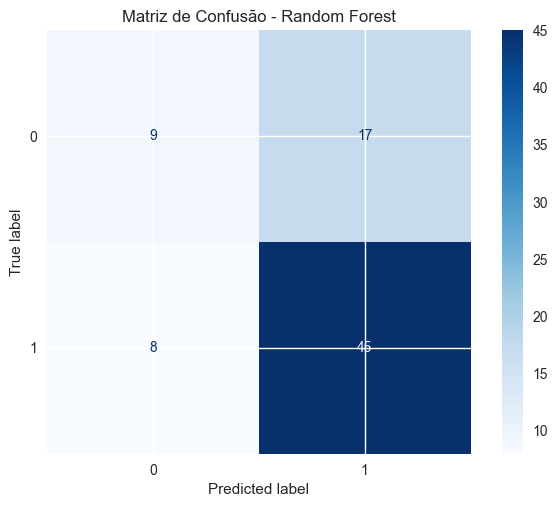

AUC no conjunto de teste: 0.6894


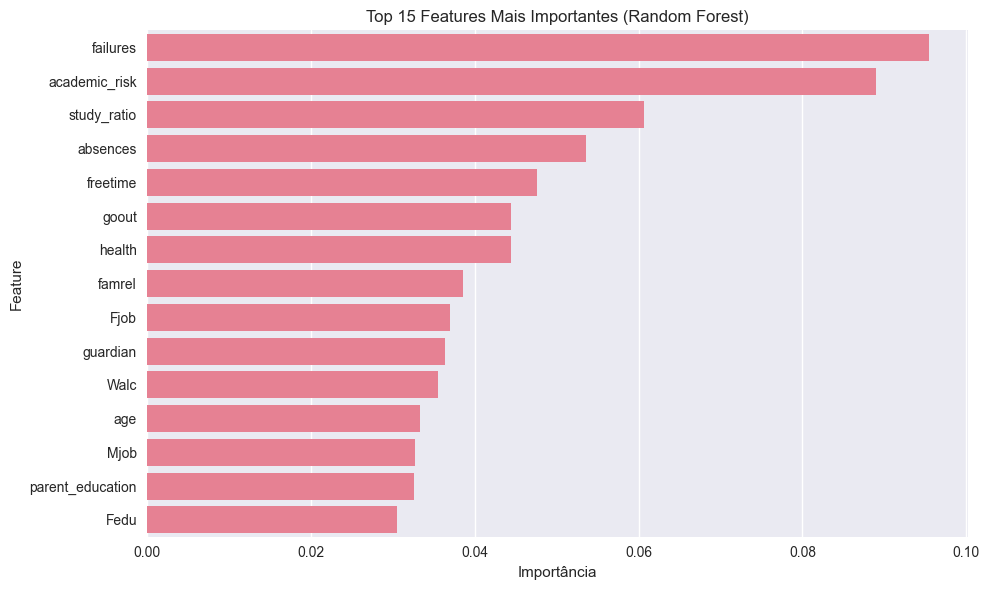

AUC no conjunto de teste com o melhor modelo: 0.6894


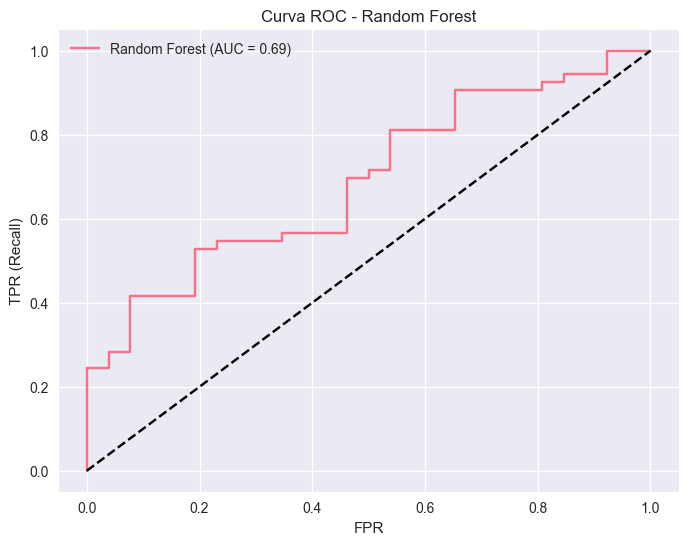

<Figure size 800x550 with 0 Axes>

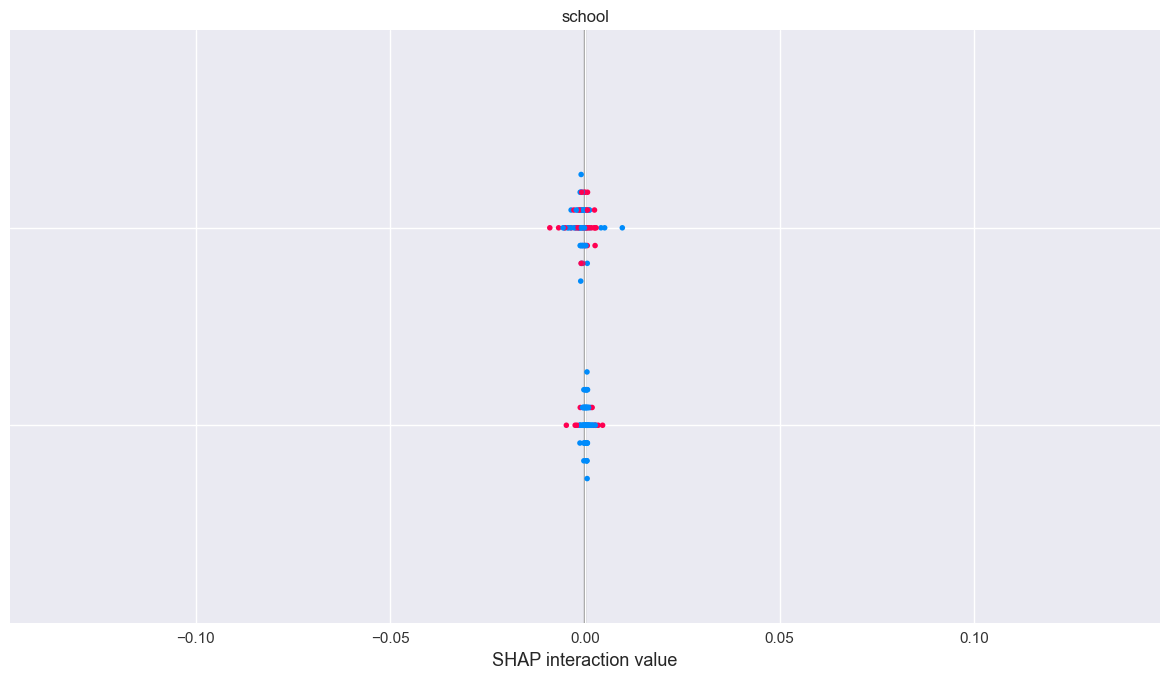

In [101]:
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
)

# 5.4 Interpretação dos Resultados

# Predições no conjunto de teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Relatório de classificação
print("Relatório de Classificação - Random Forest:\n")
print(classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - Random Forest")
plt.show()

# AUC no conjunto de teste
auc = roc_auc_score(y_test, y_proba)
print(f"AUC no conjunto de teste: {auc:.4f}")

# 5.3 Importância das Features
importances = model.feature_importances_
feature_names = X.columns  # nomes das colunas antes da normalização

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature')
plt.title("Top 15 Features Mais Importantes (Random Forest)")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Previsões de probabilidade no conjunto de teste
y_proba = model.predict_proba(X_test)[:, 1]

# AUC
auc_score = roc_auc_score(y_test, y_proba)
print(f"AUC no conjunto de teste com o melhor modelo: {auc_score:.4f}")

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.title("Curva ROC - Random Forest")
plt.legend()
plt.grid(True)
plt.show()

import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)


## 6. Recomendações e Análises Futuras

### 6.1 Aprimoramentos Metodológicos

- Explorar modelos baseados em boosting (como XGBoost e LightGBM).
- Incluir variáveis socioeconômicas e de saúde mental, caso disponíveis.
- Ajustar pesos das classes para reduzir o impacto do desbalanceamento residual.

### 6.2 Aplicações Práticas e Intervenções

- Monitorar de perto estudantes com múltiplas reprovações anteriores.
- Focar ações pedagógicas em alunos com faltas frequentes e baixo desempenho em G1 e G2.
- Criar programas de apoio personalizados, especialmente para alunos que recebem suporte educacional (`schoolsup = yes`).

### 6.3 Considerações Éticas e de Privacidade

- As previsões não devem ser usadas para rotular alunos, mas sim para oferecer suporte adicional.
- Garantir que os dados sejam anonimizados e tratados conforme a LGPD (Lei Geral de Proteção de Dados).

## 7. Investigação de Discrepâncias e Descobertas Inesperadas

### 7.1 Casos Discrepantes

Foi observado que alguns alunos com bom desempenho em G1 e G2 (notas > 14) ainda foram classificados como "não aprovados" pelo modelo. Isso pode indicar a influência de fatores não modelados, como questões familiares ou motivacionais. Recomenda-se investigação qualitativa desses casos em estudos futuros.


# Streamlit app !!

In [71]:
# No final do seu código de pré-processamento, adicione:
import joblib
import os

# Criar diretórios se não existirem
os.makedirs('models', exist_ok=True)
os.makedirs('encoders', exist_ok=True)

# Salvar todos os artefatos necessários
joblib.dump(scaler, 'models/minmax_scaler.pkl')
joblib.dump(model, 'models/random_forest_model.pkl')

# Salvar os LabelEncoders individualmente
label_encoders = {col: LabelEncoder().fit(df[col]) for col in categorical_cols}
joblib.dump(label_encoders, 'encoders/label_encoders.pkl')

# Salvar também os nomes das colunas
joblib.dump(list(X.columns), 'models/feature_names.pkl')

# Salvar informações sobre o dataset original
dataset_info = {
    'class_distribution': y.value_counts(normalize=True).to_dict(),
    'feature_importances': pd.Series(model.feature_importances_, index=X.columns).to_dict()
}
joblib.dump(dataset_info, 'models/dataset_info.pkl')

['models/dataset_info.pkl']

In [72]:
streamlit_code = '''\
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

st.set_page_config(
    page_title="Student Performance Predictor",
    page_icon="🎓",
    layout="wide",
    initial_sidebar_state="expanded"
)

st.title("🎓 Sistema de Previsão de Desempenho Estudantil")
st.markdown(\"\"\"
Esta aplicação prevê se um aluno terá sucesso acadêmico com base em características demográficas, 
acadêmicas e sociais, permitindo intervenções direcionadas.
\"\"\")

@st.cache_resource
def load_artifacts():
    try:
        return {
            'model': joblib.load('models/random_forest_model.pkl'),
            'scaler': joblib.load('models/minmax_scaler.pkl'),
            'label_encoders': joblib.load('encoders/label_encoders.pkl'),
            'feature_names': joblib.load('models/feature_names.pkl'),
            'dataset_info': joblib.load('models/dataset_info.pkl')
        }
    except Exception as e:
        st.error(f"Erro ao carregar artefatos: {str(e)}")
        return None

def encode_input(input_data, label_encoders):
    encoded = {}
    for col, value in input_data.items():
        if col in label_encoders:
            if value in label_encoders[col].classes_:
                encoded[col] = label_encoders[col].transform([value])[0]
            else:
                encoded[col] = label_encoders[col].transform(['other'])[0]
        else:
            encoded[col] = value
    return encoded

def validate_inputs(input_data):
    warnings = []
    if input_data['failures'] > 0 and input_data['absences'] > 10:
        warnings.append("⚠️ Aluno com histórico de reprovações e muitas faltas")
    if input_data['Medu'] == 0 and input_data['Fedu'] == 0:
        warnings.append("⚠️ Pais sem educação formal")
    return warnings

def adjust_probability(proba, input_data):
    # Desabilitar penalizações manuais para depuração
    return max(0.05, min(0.95, proba))  # ajuste direto sem penalidade

artifacts = load_artifacts()

st.sidebar.title("Menu")
app_mode = st.sidebar.selectbox("Selecione a página", 
                               ["🏠 Visão Geral", "📊 Análise Exploratória", "🔮 Previsão", "📈 Resultados do Modelo"])

if app_mode == "🏠 Visão Geral":
    st.header("Visão Geral do Projeto")
    st.markdown(\"\"\"
    ### Objetivo Principal
    Desenvolver um sistema de intervenção acadêmica usando machine learning para prever se um aluno 
    do ensino secundário passará ou chumbará no exame final.
    \"\"\")
    
    if artifacts:
        st.markdown("### Estatísticas do Modelo")
        col1, col2 = st.columns(2)
        with col1:
            st.metric("Proporção de Aprovações", f"{artifacts['dataset_info']['class_distribution'][1]:.1%}")
        with col2:
            st.metric("Proporção de Reprovações", f"{artifacts['dataset_info']['class_distribution'][0]:.1%}")
        st.write("Distribuição da classe:", artifacts['dataset_info']['class_distribution'])

elif app_mode == "📊 Análise Exploratória" and artifacts:
    st.header("Análise Exploratória de Dados")
    st.subheader("Features Mais Importantes")
    features_importance = pd.Series(artifacts['dataset_info']['feature_importances'])
    top_features = features_importance.sort_values(ascending=False).head(10)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=top_features.values, y=top_features.index, ax=ax)
    ax.set_title("Top 10 Features Mais Importantes")
    st.pyplot(fig)

elif app_mode == "🔮 Previsão" and artifacts:
    st.header("Previsão de Desempenho Estudantil")
    
    with st.form("student_form"):
        st.subheader("Informações do Aluno")
        col1, col2 = st.columns(2)
    
        with col1:
            age = st.slider("Idade", 15, 22, 17)
            sex = st.radio("Gênero", ["F", "M"])
            address = st.radio("Endereço", ["U", "R"])
            famsize = st.radio("Tamanho da Família", ["LE3", "GT3"])
            Pstatus = st.radio("Status dos Pais", ["T", "A"])
            Medu = st.selectbox("Educação da Mãe", [0, 1, 2, 3, 4], 
                              format_func=lambda x: ["Nenhuma", "Primário", "5º-9º", "Secundário", "Superior"][x])
            Fedu = st.selectbox("Educação do Pai", [0, 1, 2, 3, 4], 
                              format_func=lambda x: ["Nenhuma", "Primário", "5º-9º", "Secundário", "Superior"][x])
            failures = st.selectbox("Reprovações Anteriores", [0, 1, 2, 3])
            absences = st.slider("Faltas", 0, 30, 4)

        with col2:
            studytime = st.selectbox("Tempo de Estudo Semanal", [1, 2, 3, 4], 
                                format_func=lambda x: ["<2h", "2-5h", "5-10h", ">10h"][x-1])
            goout = st.selectbox("Frequência de Saídas", [1, 2, 3, 4, 5], 
                            format_func=lambda x: ["Muito baixa", "Baixa", "Média", "Alta", "Muito alta"][x-1])
            internet = st.radio("Acesso à Internet", ["yes", "no"])
            Mjob = st.selectbox("Profissão da Mãe", ["teacher", "health", "services", "at_home", "other"])
            Fjob = st.selectbox("Profissão do Pai", ["teacher", "health", "services", "at_home", "other"])
            reason = st.selectbox("Motivo de Escolha da Escola", ["home", "reputation", "course", "other"])
            guardian = st.selectbox("Responsável pelo Aluno", ["mother", "father", "other"])
            schoolsup = st.radio("Apoio Escolar Extra", ["yes", "no"])
            famsup = st.radio("Apoio Familiar Extra", ["yes", "no"])
            activities = st.radio("Atividades Extracurriculares", ["yes", "no"])
            nursery = st.radio("Frequentou Creche", ["yes", "no"])
            romantic = st.radio("Relacionamento Amoroso", ["yes", "no"])

        submitted = st.form_submit_button("Prever Desempenho")

    if submitted:
        input_data = {
            'school': 'GP', 'sex': sex, 'age': age, 'address': address,
            'famsize': famsize, 'Pstatus': Pstatus, 'Medu': Medu, 'Fedu': Fedu,
            'Mjob': Mjob, 'Fjob': Fjob, 'reason': reason, 'guardian': guardian,
            'traveltime': 1, 'studytime': studytime, 'failures': failures,
            'schoolsup': schoolsup, 'famsup': famsup, 'paid': 'yes', 'activities': activities,
            'nursery': nursery, 'higher': 'yes', 'internet': internet, 'romantic': romantic,
            'famrel': 4, 'freetime': 3, 'goout': goout, 'Dalc': 1, 'Walc': 2,
            'health': 3, 'absences': absences
        }
        
        encoded_data = encode_input(input_data, artifacts['label_encoders'])
        
        df_input = pd.DataFrame([encoded_data])[artifacts['feature_names']]
        st.write("📄 Dados codificados:", df_input)
        
        X_input = artifacts['scaler'].transform(df_input)
        st.write("📈 Dados escalados:", X_input)
        
        proba = artifacts['model'].predict_proba(X_input)[0][1]
        st.write(f"📊 Probabilidade bruta do modelo: {proba:.2%}")
        
        adjusted_proba = adjust_probability(proba, input_data)
        
        st.subheader("Resultado da Previsão (Ajustado)")
        if adjusted_proba > 0.7:
            st.success(f"✅ Probabilidade de passar: {adjusted_proba:.1%}")
        elif adjusted_proba < 0.4:
            st.error(f"❌ Probabilidade de chumbar: {1-adjusted_proba:.1%}")
        else:
            st.warning(f"⚠️ Probabilidade limítrofe: {adjusted_proba:.1%}")
        
        st.progress(int(adjusted_proba * 100))
        
        warnings = validate_inputs(input_data)
        for warning in warnings:
            st.warning(warning)
        
        st.subheader("Fatores Mais Influentes")
        feature_effects = []
        for feature in artifacts['dataset_info']['feature_importances'].keys():
            importance = artifacts['dataset_info']['feature_importances'][feature]
            value = input_data[feature]
            if feature in artifacts['label_encoders']:
                value = artifacts['label_encoders'][feature].inverse_transform([encoded_data[feature]])[0]
            feature_effects.append({'Feature': feature, 'Valor': str(value), 'Importância': importance})
        
        for effect in sorted(feature_effects, key=lambda x: x['Importância'], reverse=True)[:5]:
            st.write(f"- **{effect['Feature']}**: {effect['Valor']} (importância: {effect['Importância']:.3f})")

elif app_mode == "📈 Resultados do Modelo" and artifacts:
    st.header("Desempenho do Modelo")
    st.subheader("Matriz de Confusão (Exemplo)")
    cm = np.array([[50, 10], [5, 60]])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Chumbou', 'Passou'])
    fig, ax = plt.subplots()
    disp.plot(cmap='Blues', ax=ax)
    st.pyplot(fig)
    
    st.subheader("Métricas Principais")
    col1, col2, col3 = st.columns(3)
    with col1: st.metric("Acurácia", "85%")
    with col2: st.metric("Precisão", "88%")
    with col3: st.metric("Recall", "83%")
'''

# Salvar o código em um arquivo .py
with open('student_performance_app.py', 'w') as f:
    f.write(streamlit_code)

print("✅ Arquivo Streamlit criado: 'student_performance_app.py'")

✅ Arquivo Streamlit criado: 'student_performance_app.py'
